<a href="https://colab.research.google.com/github/yakhoruzhenko/cat-vs-dogo/blob/main/dog_cat_breed_0_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

import tensorflow as tf
from keras.layers import Input, TFSMLayer
from keras.models import Model

In [29]:
#UNZIPPING PRETRAINED MODELS AND CREATING MODELS VARIABLES
urls = {
    "dvc": "https://raw.githubusercontent.com/yarusx/cat-vs-dogo/main/models/dvc.zip",
    "dogs": "https://raw.githubusercontent.com/yarusx/cat-vs-dogo/main/models/dogs_breeds.zip",
    "cats": "https://raw.githubusercontent.com/yarusx/cat-vs-dogo/main/models/cats_breeds.zip"
}

extract_dirs = {
    "dvc": "/tmp/dvc",
    "dogs": "/tmp/dogs",
    "cats": "/tmp/cats"
}

# Download and extract ZIP files
for name, url in urls.items():
    zip_file_path = os.path.join(extract_dirs[name], os.path.basename(url))
    if not os.path.exists(extract_dirs[name]):
        print(f"Downloading {name} to {extract_dirs[name]} ...")
        !wget -q --no-check-certificate "{url}" -P "{extract_dirs[name]}"
    else:
        print(f"{extract_dirs[name]} already exists, skipping.")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dirs[name])
    # Show the content of the newly created folder from unzipping
    !find /tmp/"{name}" -type f

# Load TFSMLayers
dvc_layer = TFSMLayer("/tmp/dvc/content/saved_model/dvc", call_endpoint="serving_default")
dogs_layer = TFSMLayer("/tmp/dogs/saved_model/dogs", call_endpoint="serving_default")
cats_layer = TFSMLayer("/tmp/cats/saved_model/cats", call_endpoint="serving_default")

# Create models by wrapping the TFSMLayers
input_tensor = Input(shape=(160, 160, 3))

# Classification model: Dog vs Cat
dvc_model = Model(inputs=input_tensor, outputs=dvc_layer(input_tensor))

# Breed models
dogs_model = Model(inputs=input_tensor, outputs=dogs_layer(input_tensor))
cats_model = Model(inputs=input_tensor, outputs=cats_layer(input_tensor))

/tmp/dvc already exists, skipping.
/tmp/dvc/dvc.zip
/tmp/dvc/content/saved_model/dvc/variables/variables.data-00000-of-00001
/tmp/dvc/content/saved_model/dvc/variables/variables.index
/tmp/dvc/content/saved_model/dvc/saved_model.pb
/tmp/dogs already exists, skipping.
/tmp/dogs/saved_model/dogs/variables/variables.data-00000-of-00001
/tmp/dogs/saved_model/dogs/variables/variables.index
/tmp/dogs/saved_model/dogs/saved_model.pb
/tmp/dogs/dogs_breeds.zip
/tmp/cats already exists, skipping.
/tmp/cats/saved_model/cats/variables/variables.data-00000-of-00001
/tmp/cats/saved_model/cats/variables/variables.index
/tmp/cats/saved_model/cats/saved_model.pb
/tmp/cats/cats_breeds.zip


In [30]:
# LISTS OF DOGS AND CATS BREEDS
d_breeds = [
    'pug', 'basset_hound', 'shiba_inu', 'leonberger', 'saint_bernard', 'miniature_pinscher',
    'wheaten_terrier', 'scottish_terrier', 'pomeranian', 'german_shorthaired', 'english_setter',
    'newfoundland', 'boxer', 'great_pyrenees', 'samoyed', 'japanese_chin', 'english_cocker_spaniel',
    'havanese', 'american_pit_bull_terrier', 'keeshond', 'american_bulldog', 'chihuahua', 'beagle',
    'yorkshire_terrier', 'staffordshire_bull_terrier'
]
c_breeds = [
    'egyptian_mau', 'siamese', 'birman', 'abyssinian', 'sphynx', 'british_shorthair', 'bombay',
    'russian_blue', 'persian', 'ragdoll', 'maine_coon', 'bengal'
]

In [31]:
# Breed prediction and visualization
def breed_id(dog, model, img_as_arr):
    pred = model.predict(img_as_arr, batch_size=1)
    if isinstance(pred, dict):
        pred = list(pred.values())[0]
    pred = tf.nn.softmax(pred)
    breed_idx = tf.argmax(pred, axis=1).numpy()[0]

    plt.figure(figsize=(4, 4))
    plt.imshow(img_as_arr[0] / 255.0)
    plt.axis('off')
    breed_name = d_breeds[breed_idx] if dog else c_breeds[breed_idx]
    plt.title(f'Breed name: {breed_name}')
    plt.show()

Saving lab.jpg to lab.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
There is a **dog** on the uploaded file
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


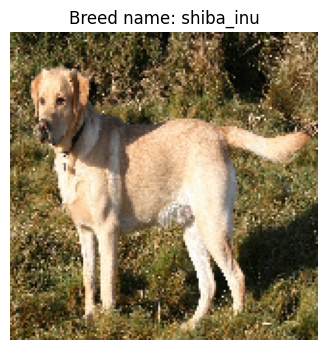

In [32]:
#UPLOAD YOUR PICTURES TO PREDICT DOG OR CAT AND ITS BREED
uploaded = files.upload()

for path in uploaded.keys():
    # Load and preprocess image
    img = tf.keras.utils.load_img(path, target_size=(160, 160))
    img_as_arr = tf.keras.utils.img_to_array(img)
    img_as_arr = np.expand_dims(img_as_arr, axis=0)

    # Predict dog vs cat
    pred = dvc_model.predict(img_as_arr, batch_size=1)
    pred = tf.nn.sigmoid(pred['dense']).numpy()[0][0]

    if pred > 0.5:
        print(f"There is a **dog** on the uploaded file")
        breed_id(dog=True, model=dogs_model, img_as_arr=img_as_arr)
    else:
        print(f"There is a **cat** on the uploaded file")
        breed_id(dog=False, model=cats_model, img_as_arr=img_as_arr)